# Efficiency plots
## Summary
* Loading the data
* Defining convenient functions to unfold LightCurves
* Initialize tables and matching distance tolerance
* Producing the actual matching
* Producing the plots

In [1]:
import os
import sqlite3

In [2]:
os.environ['SCRATCH']='/global/cscratch1/sd/bos0109'
SCRATCH = %env SCRATCH

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
from matplotlib.ticker import PercentFormatter

In [85]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import colors

In [118]:
import seaborn as sns
sns.set_context('talk')

In [5]:
%matplotlib inline

In [6]:
from glob import glob

In [7]:
from astropy import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

### Loading the data
 We are loading the data from a set of files already produced and stored.
 The files contain the truth catalog for SN Ia and their parameters, as well
 a HDF5 storage container with the `diaSrc` catalogs stacked as a single table.

In [8]:
truth_lightc = pd.read_csv('../lightcurves/lightcurves_cat_rect_58.0_56.0_-31.0_-32.0.csv')
sntab = pd.read_csv('../catalogs+tables/supernovae_cat_rect_58.0_56.0_-31.0_-32.0.csv')
#truth_lightc = pd.read_csv('./lightcurves/lightcurves_cat_rect_58_56_-31_-32.csv')
#sntab = pd.read_csv('./catalogs+tables/supernovae_cat_rect_58_56_-31_-32.csv')

In [9]:
#diaSrc_store = pd.HDFStore('/global/cscratch1/sd/bos0109/diaSrc_forced_fulltables_v4.h5')
diaSrc_store = pd.HDFStore(f'{SCRATCH}/results/diaSrc_secrun_fulltables_v4.h5')
diaSrc_store.open()
metacols = ['id', 'visit', 'filter', 'raftName', 'detectorName', 'detector']

### Defining convenient functions 

* Dealing with the truth catalog table and the SN parameters table is best achieved if encapsulated as single functions

In [10]:
def get_truth_LC(truth_tab, snid):
    sffx = ('_observable', '_observed', '_flux', '_fluxErr', '_mag', '_magErr')
    snid = str(snid)
    colset = ['mjd', 'filter', 'visitn'] + [snid+acol for acol in sffx]
    tab = truth_tab[colset].copy()
    transl = {snid+acol: acol[1:] for acol in sffx}
    tab.rename(columns=transl, inplace=True)
    tab['snid_in'] = snid
    return tab[tab.observable]

* Unfold the lightcurves from the table using the above function

In [11]:
snids = [acol.strip('_observed') for acol in truth_lightc.columns 
        if '_observed' in acol]
lcs = []
for asnid in snids:
    lcs.append(get_truth_LC(truth_lightc, asnid))
lcs = pd.concat(lcs)

### Defining the tolerance and table lists

In [12]:
diasrc_tab = diaSrc_store['full_table']

d_tol = 2.5*u.arcsec
lc_list = []
visits_used = []
diasrc_list = []
N_matches = 0

In [13]:
diaSrc_store.close()

### Matching 
* Using the visit number as the grouping column in the `diaSrc` table 
* Comparing sky positions with the SN and `diaSrc` instances

In [14]:
lcs['visit_used'] = False

In [15]:
for avisit, atab in diasrc_tab.groupby('visit_n'):
    # light curve row:
    lc = lcs.loc[lcs['visitn']==avisit].copy()
    snlist = sntab[sntab.snid_in.isin(lc.snid_in)]
    
    if lc.empty or snlist.empty:
        continue
    
    lcs.loc[lcs['visitn']==avisit, 'visit_used'] = True
    visits_used.append(avisit)
    #print(avisit)
    sncoords = SkyCoord(ra=snlist.snra_in*u.deg, dec=snlist.sndec_in*u.deg)

    #srctab = atab[~atab.base_PixelFlags_flag_saturated].copy()
    #srctab = srctab[~srctab.base_PixelFlags_flag_edge].copy()
    #srctab = srctab[~srctab.ip_diffim_DipoleFit_flag_classification].copy()
    srctab = atab.copy()
    diacoords = SkyCoord(ra=srctab.coord_ra*u.rad, dec=srctab.coord_dec*u.rad)
    
    idx, d2d, d3d = sncoords.match_to_catalog_sky(diacoords)
    idx_, d2d_, d3d_ = diacoords.match_to_catalog_sky(sncoords)

    match = np.repeat(False, len(idx))
    matchO = np.repeat(False, len(idx_))
    not_matched = []
    for i in range(len(idx)):
        if i==idx_[idx[i]] and d2d[i]<d_tol and d2d_[idx[i]]<d_tol:
            match[i] = True
            matchO[idx[i]] = True
        else:
            not_matched.append([i, idx[i], idx_[idx[i]]])
    not_matched = np.array(not_matched)
    lc['matched'] = match
    lc['match_ang_dist'] = d2d.to(u.arcsec)
    lc['dia_row'] = idx
    lc['dia_id'] = srctab.iloc[idx]['id'].values

    srctab['cxmatch'] = matchO
    srctab['sn_row'] = idx_
    srctab['match_ang_dist'] = d2d_.to(u.arcsec)
    srctab['sn_id'] = lc.iloc[idx_]['snid_in'].values

    N_matches += np.sum(match)

    lc_list.append(lc)
    diasrc_list.append(srctab)
print(N_matches)

1432


In [16]:
matched_lcs = pd.concat(lc_list)
matched_diasrc = pd.concat(diasrc_list)

In [17]:
len(matched_lcs)

10971

In [18]:
np.sum(matched_lcs['matched'])

1432

In [19]:
len(matched_diasrc)

636408

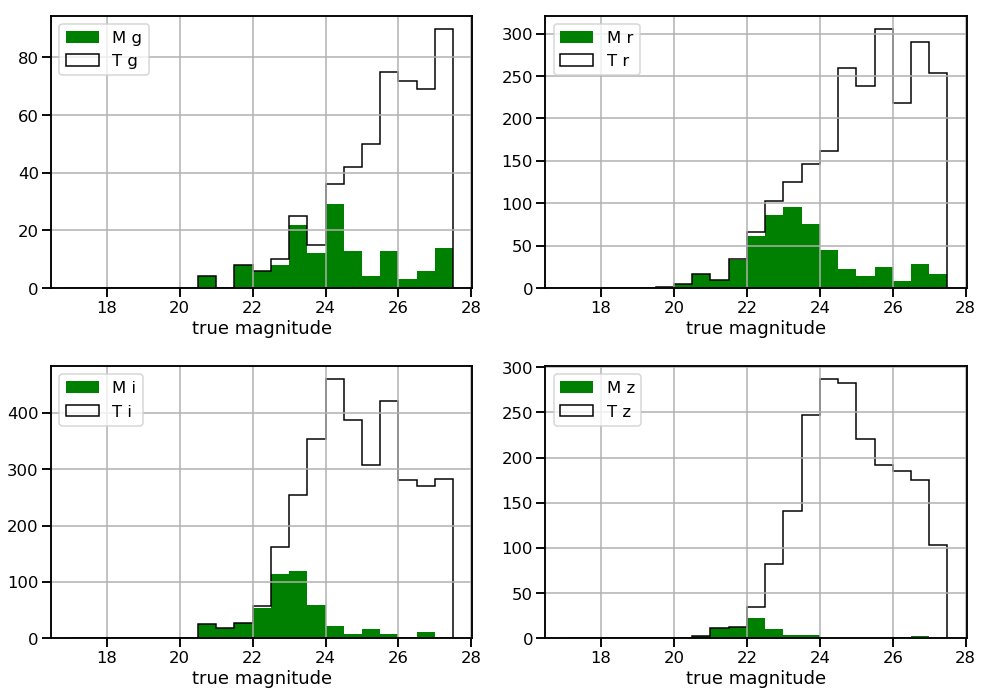

In [152]:
bandpasses = ('g', 'r', 'i', 'z')
bins=np.arange(17, 28, 0.5)
fig, axes = plt.subplots(figsize=(14, 10), nrows=2, ncols=2)

for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]

    ax.hist(subtab[subtab.matched].mag, histtype='stepfilled', lw=0.5, 
            bins=bins, color='green', label=f'M {band}', alpha=1.)
    ax.hist(subtab.mag, histtype='step', lw=1.5, color='k', bins=bins, 
            label=f'T {band}')

    ax.set_xlabel('true magnitude')
    ax.legend(loc='upper left')
    ax.grid()
plt.tight_layout()

plt.savefig('graphs/matched_lcs.png')
#plt.clf()

/global/common/software/lsst/common/miniconda/py3-4.5.12/envs/stack/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


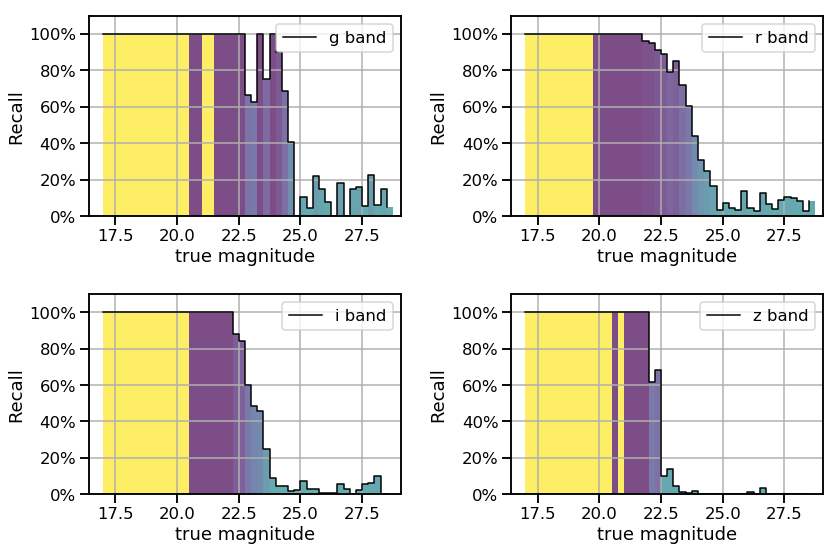

In [147]:
bandpasses = ('g', 'r', 'i', 'z')
wid = 0.25
bins=np.arange(17, 29, wid)
redges = bins[:-1] #+ wid/2.
fig, axes = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for ax, band in zip(axes.flatten(), bandpasses):
    subtab = matched_lcs.loc[matched_lcs['filter']==band]
    
    counts, mbins = np.histogram(subtab.mag, bins=bins)
    mcount, mbins = np.histogram(subtab[subtab.matched].mag, bins=bins)
    eff = mcount/counts
    eff[np.where(counts==0.)] = 1.
    ax.step(redges, eff, 'k', where='post', lw=1.5, label=band+' band')
    
    patches = []
    norm = colors.Normalize(0, 1)
    for abin, aneff, co in zip(redges, eff, counts):
        patch = Rectangle((abin, 0.), wid, aneff)
        patches.append(patch)
    pcolors = norm(eff)
    pcolors[np.where(counts==0.)] = -1.
    ax.grid()
    collection = PatchCollection(patches, cmap=plt.cm.viridis_r, alpha=0.7)
    collection.set_array(pcolors)
    ax.add_collection(collection)
    
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('true magnitude')
    ax.set_ylabel('Recall')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.legend(loc='upper right')
    
plt.tight_layout()
plt.savefig('graphs/Recall.png')